In [1]:
import pandas as pd
from sklearn.linear_model import ElasticNetCV
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
import numpy as np
from numpy import arange
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
import sys
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    warnings.filterwarnings('ignore')
    


In [2]:
def read_data():
    df = pd.read_csv("https://raw.githubusercontent.com/thistleknot/Python-Stock/master/data/raw/states.csv").set_index('States')
    return(df)

In [3]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# ------------------------------------
# file: zca.py
# date: Thu May 21 15:47 2015
# author:
# Maarten Versteegh
# github.com/mwv
# maartenversteegh AT gmail DOT com
#
# Licensed under GPLv3
# ------------------------------------
"""zca: ZCA whitening with a sklearn-like interface

"""

from __future__ import division

import numpy as np
from scipy import linalg

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, as_float_array

class ZCA(BaseEstimator, TransformerMixin):
    def __init__(self, regularization=1e-6, copy=False):
        self.regularization = regularization
        self.copy = copy

    def fit(self, X, y=None):
        """Compute the mean, whitening and dewhitening matrices.

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data used to compute the mean, whitening and dewhitening
            matrices.
        """
        X = check_array(X, accept_sparse=None, copy=self.copy,
                        ensure_2d=True)
        X = as_float_array(X, copy=self.copy)
        self.mean_ = X.mean(axis=0)
        X_ = X - self.mean_
        cov = np.dot(X_.T, X_) / (X_.shape[0]-1)
        U, S, _ = linalg.svd(cov)
        s = np.sqrt(S.clip(self.regularization))
        s_inv = np.diag(1./s)
        s = np.diag(s)
        self.whiten_ = np.dot(np.dot(U, s_inv), U.T)
        self.dewhiten_ = np.dot(np.dot(U, s), U.T)
        return self

    def transform(self, X, y=None, copy=None):
        """Perform ZCA whitening

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to whiten along the features axis.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X - self.mean_, self.whiten_.T)

    def inverse_transform(self, X, copy=None):
        """Undo the ZCA transform and rotate back to the original
        representation

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to rotate back.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X, self.dewhiten_) + self.mean_


In [4]:
independent = 'Poverty'

In [5]:
y = read_data()[[independent]]
X = read_data()[(read_data().columns).difference([independent]).values]

In [6]:
estimators = []
estimators.append(('standardize', ZCA()))
estimators.append(('ElasticNetCV', ElasticNetCV(cv=10, random_state=0)))
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
#estimators.append(('ElasticNetCV', ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)))
model = Pipeline(estimators)

model.fit(X, y)
#print('alpha: %f' % model.alphas)
#print('l1_ratio_: %f' % model.l1_ratio)


Pipeline(steps=[('standardize', ZCA()),
                ('ElasticNetCV', ElasticNetCV(cv=10, random_state=0))])

In [7]:
model.score(X,y)

0.8609356681998442

In [8]:
model.get_params()

{'memory': None,
 'steps': [('standardize', ZCA()),
  ('ElasticNetCV', ElasticNetCV(cv=10, random_state=0))],
 'verbose': False,
 'standardize': ZCA(),
 'ElasticNetCV': ElasticNetCV(cv=10, random_state=0),
 'standardize__copy': False,
 'standardize__regularization': 1e-06,
 'ElasticNetCV__alphas': None,
 'ElasticNetCV__copy_X': True,
 'ElasticNetCV__cv': 10,
 'ElasticNetCV__eps': 0.001,
 'ElasticNetCV__fit_intercept': True,
 'ElasticNetCV__l1_ratio': 0.5,
 'ElasticNetCV__max_iter': 1000,
 'ElasticNetCV__n_alphas': 100,
 'ElasticNetCV__n_jobs': None,
 'ElasticNetCV__normalize': False,
 'ElasticNetCV__positive': False,
 'ElasticNetCV__precompute': 'auto',
 'ElasticNetCV__random_state': 0,
 'ElasticNetCV__selection': 'cyclic',
 'ElasticNetCV__tol': 0.0001,
 'ElasticNetCV__verbose': 0}

In [9]:
results = cross_val_score(model, X, y, cv=cv)

In [10]:
results

array([ 0.6359295 ,  0.89726432,  0.94487683,  0.63892249,  0.67139652,
       -0.13444101,  0.80174153,  0.90693939,  0.83291332,  0.41320671,
        0.93914589,  0.80081269,  0.28881888,  0.30030918,  0.90993784,
        0.69230169,  0.67620445,  0.66781782,  0.75809788,  0.87535852,
        0.60698596,  0.81575621,  0.89281156,  0.97067134,  0.43092841,
        0.15104642,  0.07861483,  0.68202931,  0.86368869,  0.65555619])

In [11]:
#X, y = make_regression(n_features=2, random_state=0)
#regr = ElasticNetCV(cv=10, random_state=0)
#regr.fit(X, y)
#print(regr.alpha_)
#print(regr.intercept_)
#print(regr.predict(X))

In [12]:
model.predict(X)

array([15.69792116,  8.98061296, 13.0260891 , 16.2048984 , 12.92431152,
       10.9728195 ,  8.08528569, 10.64855536, 15.05280887, 14.28616325,
       10.55573198, 12.87717078, 12.35084567, 13.28036971, 12.27479433,
       12.43755199, 15.52434214, 15.86168769, 13.12836638,  8.43193781,
        9.17396981, 14.36335051, 10.71691314, 18.0642663 , 14.12183856,
       15.26465842, 11.99440543, 11.67958584,  7.97996317,  8.1878938 ,
       14.4211433 , 12.9706684 , 15.26263741, 13.13344354, 13.96911895,
       14.56848314, 13.13860365, 13.32806397, 11.66319775, 16.24271397,
       13.15822286, 15.47851188, 14.02465684,  9.90234021, 11.5156554 ,
       10.49360017, 10.83922258, 15.68581496, 11.94741646, 10.70737528])

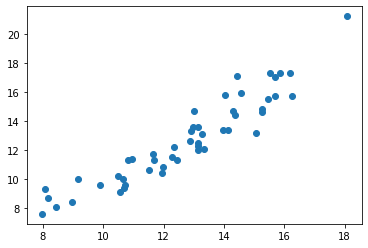

In [13]:
plt.scatter(model.predict(X),y)

In [14]:
#chosen_model = ElasticNet(alpha=model.named_steps['ElasticNetCV'].alpha_, l1_ratio=model.named_steps['ElasticNetCV'].l1_ratio)
#chosen_model.fit(X,y)

In [15]:
#plt.scatter(chosen_model.predict(X),y)

In [16]:
#pd.DataFrame(model.predict(X)-chosen_model.predict(X)).hist()

In [17]:
filtered = X.columns[model.named_steps['ElasticNetCV'].coef_!=0]

#from statsmodels.formula.api import ols
sm_model = sm.OLS(y, sm.add_constant(X[filtered])).fit()
sm_model.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Poverty   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     42.47
Date:                Tue, 19 Apr 2022   Prob (F-statistic):           4.79e-17
Time:                        20:49:32   Log-Likelihood:                -72.116
No. Observations:                  50   AIC:                             160.2
Df Residuals:                      42   BIC:                             175.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          26.0438      3.622      7.190      0.000      18.734      33.353
Crime          -0.0004      0.001     -0.384      0.703      -0.003       0.002
Doctors         0.0055      0.003      1.598      0.118      -0.001       0.012
Income         -0.0003   2.98e-05     -9.668      0.000      -0.000      -0.000
Population   7.831e-08   2.74e-08      2.862      0.007    2.31e-08    1.34e-07
Traf Deaths     1.5103      0.759      1.990      0.053      -0.021       3.042
Unemployed      0.4037      0.149      2.710      0.010       0.103       0.704
White          -0.0525      0.017     -3.144      0.003      -0.086      -0.019
==============================================================================
Omnibus:                        2.719   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.257   Jarque-Bera (JB):                2.209
Skew:                           0.515   Prob(JB):                        0.331
Kurtosis:                       3.007   Cond. No.                     2.08e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
zca = ZCA()

In [19]:
sm_model_zca = sm.OLS(y, sm.add_constant(pd.DataFrame(zca.fit_transform(X[filtered]),columns=filtered)).set_index(y.index)).fit()
sm_model_zca.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Poverty   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     42.47
Date:                Tue, 19 Apr 2022   Prob (F-statistic):           4.79e-17
Time:                        20:49:32   Log-Likelihood:                -72.116
No. Observations:                  50   AIC:                             160.2
Df Residuals:                      42   BIC:                             175.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.7320      0.158     80.606      0.000      12.413      13.051
Crime           0.4798      0.160      3.007      0.004       0.158       0.802
Doctors         0.1963      0.160      1.230      0.225      -0.126       0.518
Income         -2.5276      0.160    -15.841      0.000      -2.850      -2.206
Population      0.4195      0.160      2.629      0.012       0.097       0.741
Traf Deaths     0.3125      0.160      1.959      0.057      -0.009       0.635
Unemployed      0.3949      0.160      2.475      0.017       0.073       0.717
White          -0.6939      0.160     -4.349      0.000      -1.016      -0.372
==============================================================================
Omnibus:                        2.719   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.257   Jarque-Bera (JB):                2.209
Skew:                           0.515   Prob(JB):                        0.331
Kurtosis:                       3.007   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""